# Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import cosine, euclidean

In [2]:
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

# Exploration Data Analysis

In [3]:
TRAIN_PAIRS_PATH = "../dataset/train_pairs.parquet"
TRAIN_DATA_PATH = "../dataset/train_data.parquet"

TEST_PAIRS_PATH = "../dataset/test_pairs_wo_target.parquet"
TEST_DATA_PATH = "../dataset/test_data.parquet"

In [4]:
train_pairs = pd.read_parquet(TRAIN_PAIRS_PATH)
train_etl = pd.read_parquet(TRAIN_DATA_PATH)

test_pairs = pd.read_parquet(TEST_PAIRS_PATH)
test_etl = pd.read_parquet(TEST_DATA_PATH)

Преобразуем поле categories, выделим 3ю категорию:

In [5]:
train_etl['categories'] = train_etl['categories'].apply(lambda x: json.loads(x)["3"])
test_etl['categories'] = test_etl['categories'].apply(lambda x: json.loads(x)["3"])

Выделим ключи и значения атрибутов в отдельные колонки:

In [14]:
def parse_values(row):
  if row is None:
    return "[SEP]"
  
  parsed_row = json.loads(row).values()
  parsed_row = "; ".join([" ".join(val) for val in parsed_row])
  return parsed_row

def parse_keys(row):
  if row is None:
    return "[SEP]"
  
  parsed_row = json.loads(row).keys()
  parsed_row = "; ".join([val for val in parsed_row])
  return parsed_row

In [15]:
train_etl["attr_keys"] = train_etl['characteristic_attributes_mapping'].apply(parse_keys)
train_etl["attr_vals"] = train_etl['characteristic_attributes_mapping'].apply(parse_values)

test_etl["attr_keys"] = test_etl['characteristic_attributes_mapping'].apply(parse_keys)
test_etl["attr_vals"] = test_etl['characteristic_attributes_mapping'].apply(parse_values)

В тренировочной выборке больше категорий чем в тестовой. При этом в тестовой выборке присутствуют все категории из тренировочной:

In [18]:
train_categories = train_etl['categories'].unique()
test_categories = test_etl['categories'].unique()
print("Train categories size: ",len(train_categories))
print("Test categories size: ", len(test_categories))

Train categories size:  127
Test categories size:  74


In [19]:
common = [cat for cat in test_categories if cat in train_categories]
len(common)

74

Посчитаем количество товаров по категориям в тренировочной и тестовой выборке:

In [20]:
train_etl['categories'].value_counts()

categories
Смартфоны, планшеты, мобильные телефоны    59389
Компьютер                                  57572
Чехол                                      40775
Расходник для печати                       38878
Кабели и переходники                       26669
                                           ...  
Спортивные чехлы и сумки                       1
Охота и стрельба                               1
Солнечная, ветряная электростанция             1
Сувениры и подарки                             1
Мотоаксессуары                                 1
Name: count, Length: 127, dtype: int64

In [21]:
test_etl['categories'].value_counts()

categories
Запчасти для ноутбуков               4498
Зарядные устройства и док-станции    3640
Расходник для печати                 3099
Смарт-часы                           3031
Кабели и переходники                 2146
                                     ... 
Сценическое оборудование и свет         8
Демонстрационное оборудование           4
CD проигрыватели и плееры               2
SIM-карты                               2
Аксессуары для квадрокоптеров           1
Name: count, Length: 74, dtype: int64

Некоторые категории встречаются сильно реже других. Объединим их в одну категорию:

In [22]:
train_cat_counts = train_etl['categories'].value_counts()
train_etl['categories'] = train_etl['categories'].apply(lambda x: x if train_cat_counts[x] > 1000 else "rest")

test_cat_counts = test_etl['categories'].value_counts()
test_etl['categories'] = test_etl["categories"].apply(lambda x: x if test_cat_counts[x] > 1000 else "rest")

Найдем общие категории в тренировочной и тестовой выборке

In [25]:
train_cat_counts = dict(train_etl['categories'].value_counts())
test_cat_counts = dict(test_etl['categories'].value_counts())
train_cats_common_with_test = {k : v for k,v in train_cat_counts.items() if k in test_cat_counts.keys()}

In [26]:
sorted_train_cats = {key: train_cats_common_with_test[key] for key in sorted(train_cats_common_with_test.keys())}
sorted_test_cats = {key: test_cat_counts[key] for key in sorted(test_cat_counts.keys())}

Выполним визуализацию количества товаров в общих категориях

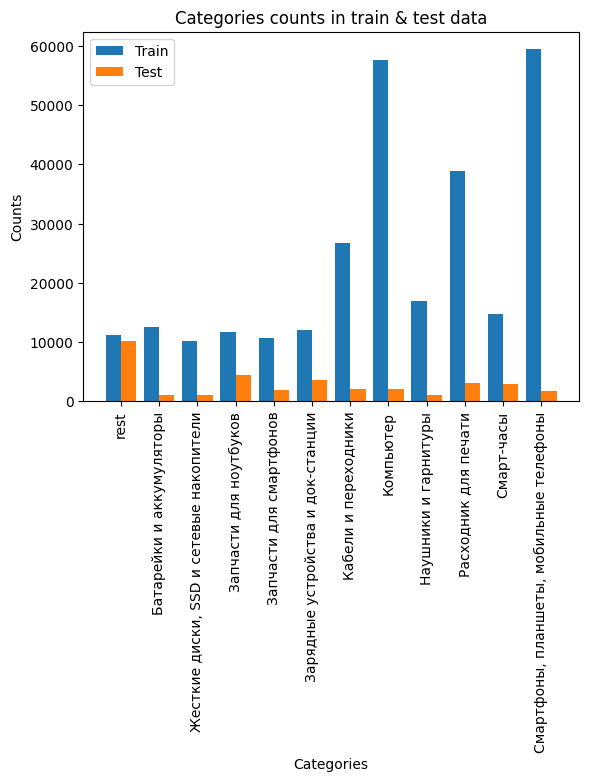

In [27]:
common_categories = sorted_train_cats.keys()
train_vals = sorted_train_cats.values()
test_vals = sorted_test_cats.values()
  
X_axis = np.arange(len(common_categories))
  
plt.bar(X_axis - 0.2, train_vals, 0.4, label='Train')
plt.bar(X_axis + 0.2, test_vals, 0.4, label='Test')
  
plt.xticks(X_axis, common_categories, rotation=90)
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.title("Categories counts in train & test data")
plt.legend()
plt.show()

In [28]:
# Соотношение тестовой выборки к тренировочной по категориям
{items_1[0] : np.round(items_1[1]/items_2[1], 3) for items_1, items_2 in zip(sorted_test_cats.items(), sorted_train_cats.items())}

{'rest': 0.9,
 'Батарейки и аккумуляторы': 0.092,
 'Жесткие диски, SSD и сетевые накопители': 0.108,
 'Запчасти для ноутбуков': 0.381,
 'Запчасти для смартфонов': 0.184,
 'Зарядные устройства и док-станции': 0.303,
 'Кабели и переходники': 0.08,
 'Компьютер': 0.035,
 'Наушники и гарнитуры': 0.062,
 'Расходник для печати': 0.08,
 'Смарт-часы': 0.205,
 'Смартфоны, планшеты, мобильные телефоны': 0.031}

In [29]:
# Соотношение тренировочной выборки к тестовой по категориям
{items_1[0] : np.round(items_1[1]/items_2[1], 3) for items_1, items_2 in zip(sorted_train_cats.items(), sorted_test_cats.items())}

{'rest': 1.111,
 'Батарейки и аккумуляторы': 10.836,
 'Жесткие диски, SSD и сетевые накопители': 9.25,
 'Запчасти для ноутбуков': 2.621,
 'Запчасти для смартфонов': 5.434,
 'Зарядные устройства и док-станции': 3.301,
 'Кабели и переходники': 12.427,
 'Компьютер': 28.222,
 'Наушники и гарнитуры': 16.168,
 'Расходник для печати': 12.545,
 'Смарт-часы': 4.887,
 'Смартфоны, планшеты, мобильные телефоны': 32.471}

# Train Data Selecting

Выберем в качестве тренировочных данных ту часть, которая соответствует категориям тестовой выборки

In [30]:
train_set = train_etl[train_etl['categories'].isin(list(common_categories))]
train_set.shape

(282849, 10)

In [31]:
train_cat_val_counts = train_set['categories'].value_counts()

Выполним undersampling для полученной тренировочной выборки:

In [32]:
LIMIT = 20_000

In [33]:
train_under_limit = train_set.groupby('categories').filter(lambda x : len(x) < LIMIT)
train_over_limit = train_set.groupby('categories').filter(lambda x : len(x) > LIMIT)

In [34]:
sampled = []
for cat_name in train_over_limit['categories'].unique():
  sample = train_over_limit[train_over_limit['categories'] == cat_name ]
  sample = sample.sample(LIMIT)
  sampled.append(sample)
undersampled = pd.concat(sampled)
undersampled.shape

(80000, 10)

In [35]:
# Наша тренировочная выборка
train_data = pd.concat([train_under_limit, undersampled])
train_data.shape

(180341, 10)

Поскольку тренировочный датасет изменился, то поменяем список тренировочных пар:

In [36]:
train_ids = train_data['variantid'].unique()

In [37]:
train_pairs[train_pairs['variantid1'].isin(train_ids)].shape

(118948, 3)

In [38]:
train_pairs[train_pairs['variantid2'].isin(train_ids)].shape

(119495, 3)

In [39]:
train_pairs[train_pairs['variantid2'].isin(train_ids)].isna().sum()

target        0
variantid1    0
variantid2    0
dtype: int64

In [40]:
train_pairs_new = train_pairs[train_pairs['variantid2'].isin(train_ids)]

Соотношение классов в новой тренировочной выборке нас устраивает:

In [41]:
train_pairs['target'].value_counts()

target
0.0    171527
1.0    135013
Name: count, dtype: int64

In [42]:
train_pairs_new['target'].value_counts()

target
0.0    65123
1.0    54372
Name: count, dtype: int64

# Data Preprocessing

Оставим те данные, которые содержат только текстовую информацию:

In [44]:
text_cols = ['variantid', 'name', 'categories', 'color_parsed', 'attr_keys','attr_vals', 'name_bert_64']
text_data = train_data[text_cols]

In [46]:
# Удалим колонки, которые не будем использовать при обучении:
text_data = text_data.drop( ["color_parsed", "name"] , axis=1)

In [47]:
text_data.head(2)

,variantid,categories,attr_keys,attr_vals,name_bert_64
4,61054740,rest,"Материал; Количество секций, шт; Цвет товара; ...",Металл; 4; черный; Apiko; 1 год; Возможность с...,"[-0.72692573, 0.75206333, 0.37740713, -0.52502..."
7,68392618,Смарт-часы,Рекомендовано для; Цвет товара; Размер цифербл...,Apple; красный; 38mm 40mm 41mm; 155; https://c...,"[-0.6567105, 0.44319087, 0.59552664, -0.450899..."


Объединим таргеты с данными:

In [48]:
train_preprocessed = (
    train_pairs_new
    .merge(
        text_data
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        text_data
        .add_suffix('2'),
        on="variantid2"
    )
)
train_preprocessed.head(2)

,target,variantid1,variantid2,categories1,attr_keys1,attr_vals1,name_bert_641,categories2,attr_keys2,attr_vals2,name_bert_642
0,1.0,53888651,89598677,Смарт-часы,Совместимость; Материал браслета; Бесконтактна...,Android PC iOS; Пластик; Нет; 30; Водонепрониц...,"[-0.45303595, 0.35168907, 0.45074046, -0.29676...",Смарт-часы,"Размеры, мм; Название цвета; Сенсорный экран; ...",45х39х14; зеленый; Да; голубой; Аккумулятор; 4...,"[-0.43019646, 0.3099462, 0.45133576, -0.297509..."
1,1.0,53888651,89581630,Смарт-часы,Совместимость; Материал браслета; Бесконтактна...,Android PC iOS; Пластик; Нет; 30; Водонепрониц...,"[-0.45303595, 0.35168907, 0.45074046, -0.29676...",Смарт-часы,"Работа в режиме ожидания, ч; Дополнительные фу...",24; Кнопка экстренного вызова; Китай; Да; Детс...,"[-0.43019646, 0.3099462, 0.45133576, -0.297509..."


In [49]:
train_preprocessed.isna().sum()

target           0
variantid1       0
variantid2       0
categories1      0
attr_keys1       0
attr_vals1       0
name_bert_641    0
categories2      0
attr_keys2       0
attr_vals2       0
name_bert_642    0
dtype: int64

In [50]:
train_preprocessed.to_parquet("../preprocessed/train_pairs_sampled_preprocessed.parquet", index=False)

Подготовим также тестовую выборку к дальнейшему использованию:

In [126]:
test_pairs.head(2)

,variantid1,variantid2,cat3_grouped
0,52076340,290590137,Батарейки и аккумуляторы
1,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны"


In [54]:
test_text = test_etl[['variantid',"color_parsed" ,'name', 'categories', 'attr_keys', 'attr_vals', 'name_bert_64']]
test_text = test_text.drop(["name", "color_parsed"], axis=1)
test_text.head(2)

,variantid,categories,attr_keys,attr_vals,name_bert_64
0,51201254,rest,Страна-изготовитель; Бренд; Входное напряжение...,Китай; TDM Electric; 250; 4; Удлинитель бытово...,"[-0.5060825, 0.5773388, 0.59435517, -0.4958292..."
1,77151532,Запчасти для ноутбуков,Страна-изготовитель; Комплектация; Бренд; Вес ...,Китай; с черной рамкой; CHIP; 120; 14 дней; К...,"[-0.43467724, 0.6614495, 0.48050267, -0.588880..."


In [55]:
test_preprocessed = (
    test_pairs
    .merge(
        test_text
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_text
        .add_suffix('2'),
        on="variantid2"
    )
)
test_preprocessed = test_preprocessed.drop("cat3_grouped", axis=1)
test_preprocessed.head(2)

,variantid1,variantid2,categories1,attr_keys1,attr_vals1,name_bert_641,categories2,attr_keys2,attr_vals2,name_bert_642
0,52076340,290590137,Батарейки и аккумуляторы,"Напряжение, В; Бренд; Тип; Форм-фактор батареи...",1.5; Perfeo; Батарейка; AAA; Щелочной; Китай; ...,"[-0.28437558, 0.60909724, 0.5972025, -0.523296...",Батарейки и аккумуляторы,Форм-фактор батареи; Химический тип; Назначени...,"AAA; Щелочной; Универсальный; Батарейка, фирме...","[-0.3380968, 0.6156224, 0.6428071, -0.57499236..."
1,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны",Операционная система; Защищенность; Навигация;...,Android; Влагозащита Ударопрочный корпус; A-GP...,"[-0.45766184, 0.5528555, 0.26298037, -0.663931...","Смартфоны, планшеты, мобильные телефоны",Встроенная память; Видеопроцессор; Степень защ...,32 ГБ; Mali-400 MP1; IP68 IP69K; 2; Ulefone; 2...,"[-0.4489074, 0.6278857, 0.33072582, -0.6749875..."


In [56]:
test_preprocessed.to_parquet("../preprocessed/test_pairs_preprocessed.parquet", index=False)